# About

Run tests to ensure that the external functions (functions.py) used across multiple notebooks are working properly.

## Tips

* For writing error messages
    * https://stackoverflow.com/questions/16451514/returning-error-string-from-a-function-in-python
* List of objects: dir()

# Setup

In [42]:
from __future__ import division, print_function, unicode_literals
import numpy as np
from numpy import random
import pandas as pd
import os, sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [4]:
# To make this notebook's output stable across runs
np.random.seed(1922)

In [5]:
# Import classes and functions used across multiple notebooks
sys.path.append(os.getcwd())
import importlib
import functions as blt

importlib.reload(blt)

Figure directory exists.
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
Figure directory exists.


<module 'functions' from '/app/src/functions.py'>

# Data

In [6]:
# Read in target (ENM) model feature data
X_enm = pd.read_csv(
    "./data/ENM-preprocessed-feats.csv", sep="\t", header="infer", index_col=0
)

# Read in source (organics) model feature data
X_source = pd.read_csv(
    "./data/organics-preprocessed-feats.csv", sep="\t", header="infer", index_col=0
)

# Read in ENM labels (maximum_weight_fraction)
y_enm = pd.read_csv("./data/ENM-clean.csv", sep=",", header="infer", usecols=[4])

# Read in organics labels (maximum_weight_fraction)
y_source = pd.read_csv(
    "./data/organics-preprocessed-WF.csv", sep="\t", header="infer", index_col=0
)
y_source.index = X_source.index

In [7]:
bin_enm = np.asarray(y_enm.apply(blt.bins, axis=1))
bin_source = np.asarray(y_source.apply(blt.bins, axis=1))

# Tests

## Imputation

In [8]:
# Plot points and fit line
def imputation_test(X, imputation_strategy="median"):

    from sklearn.impute import MissingIndicator
    from sklearn.impute import SimpleImputer

    # What is the median?
    print("Median:", X.median())

    # Identify samples missing density data
    indicator = MissingIndicator()
    is_density_null = indicator.fit_transform(np.array(X).reshape(-1, 1))
    df = X[is_density_null.reshape(-1)]
    print(type(df))

    # Impute
    imp_median = SimpleImputer(missing_values=np.nan, strategy=imputation_strategy)
    df["X_imputed"] = pd.DataFrame(
        imp_median.fit_transform(np.array(X).reshape(-1, 1))
    ).loc[is_density_null]

    return df

In [ ]:
imputation_test(X_source["cprp_density"])

## PCA

In [50]:
def pca_precheck(X, n_components, thres_btm=0.75, thres_top=0.85):
    """List PCA components for hyperparameterization

    Find a reasonable range of n_components to try during hyperparameterization.
    Returns a list of integers.

    Arguments
    ---------
    X : DataFrame
        Feature data for dimension reduction
    n_components : int
        A generous number of PCA components to test
    thres_btm : float (default=0.75)
        The minimum cumulative explained variance threshold to aim for; a fraction
    thres_top : float (default=0.85)
        The maximum cumulative explained variance threshold to aim for
    """

    from sklearn.preprocessing import MinMaxScaler
    from sklearn import decomposition

    # Scale the data first (e.g., chemical properties) from 0 to 1
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(X_scaled)
    cum_evr = np.cumsum(pca.explained_variance_ratio_)
    print(cum_evr)

    # Figure out number of components to achieve desired cumulative explained variance
    component_list = np.where((cum_evr > thres_btm) & (cum_evr < thres_top))[0] + 1
    component_list = component_list.tolist()

    if len(component_list) == 0:
        component_list = [
            next(i[0] for i in enumerate(cum_evr) if i[1] > thres_top) + 1
        ]

    # Plot just to double check / visualize
    fig = plt.figure()
    xi = np.arange(1, n_components + 1, step=1)
    plt.plot(xi, cum_evr, ".-", label="pca")
    plt.plot([0, n_components], [thres_btm, thres_btm], "k", label=thres_btm)
    plt.plot([0, n_components], [thres_top, thres_top], "r", label=thres_top)
    plt.xlabel("Coefficient Number")
    plt.ylabel("Cumulative Explained Variance Ratio")
    plt.grid()
    plt.legend()
    plt.show()

    print(component_list)
    return component_list

[0.29024958 0.40857229 0.49112146 0.56586553 0.62552707 0.67728336
 0.72335413 0.76435104 0.78726129 0.80974826 0.82771603 0.84525823
 0.85979504 0.87280657 0.88527525 0.89668188 0.90661927 0.91560422
 0.92450973 0.93242653 0.93983401 0.94630311 0.95243621 0.9585441
 0.96411347 0.96877561 0.97288469 0.97645159 0.97991518 0.98319911]


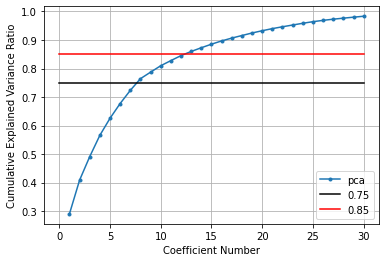

[8, 9, 10, 11, 12]


[8, 9, 10, 11, 12]

In [51]:
pca_precheck(X=X_enm, n_components=30, thres_btm=0.75, thres_top=0.85)

[0.51285579 0.8869508  0.98093052 1.        ]


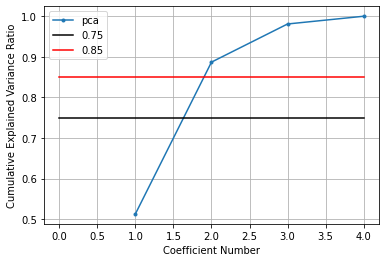

[2]


[2]

In [52]:
pca_precheck(
    X=X_enm.iloc[:, [0, 1, 2, 3]], n_components=4, thres_btm=0.75, thres_top=0.85
)

## Data Augmentation Function

First, each step in the function to be tested is run separately for each type of data augmentation to get "control" data frames. Then I attempt to recreate the same dataframe using the augment function and compare results. If they are the same, it is assumed that the function is working properly.

In [6]:
def are_equal(df1, df2):
    
    """Tests if two data frames or two arrays are equal."""
    
    if isinstance(df1, pd.DataFrame):
        # Test if data frames are equal
        print(df1.equals(df2))
    else:    
        # Test if arrays are equal
        print(np.array_equal(df1, df2))

### No augmentation

In [9]:
# Apply new function with same conditions
X_test, bin_test = blt.augment(aug_type='none', 
                               k=0, 
                               X_enm_train=X_enm, 
                               bin_enm_train=bin_enm, 
                               random_state=31)
are_equal(X_test, X_enm)
are_equal(bin_test, bin_enm)

True
True


In [10]:
# Apply new function with same conditions
X_test, bin_test = blt.augment(aug_type='none', 
                               k=1, # Should still do no augmentation even if k!=0
                               X_enm_train=X_enm, 
                               bin_enm_train=bin_enm, 
                               random_state=31)
are_equal(X_test, X_enm)
are_equal(bin_test, bin_enm)

True
True


In [11]:
# Apply new function with same conditions
X_test, bin_test = blt.augment(aug_type='random', # Should still do no augmentation
                               k=0,               # because k=0
                               X_enm_train=X_enm, 
                               bin_enm_train=bin_enm, 
                               random_state=31)
are_equal(X_test, X_enm)
are_equal(bin_test, bin_enm)

True
True


### Random augmentation

#### Control feature data frame

In [25]:
# Randomly sample source (organics) feature data and get list of their indices
idx_match_name = np.asarray(X_source.sample(n=82, 
                                            replace=False, 
                                            random_state=31, 
                                            axis=0).index)
# List first few matches
X_source.loc[idx_match_name[:8],:]

,propMW,propMP,propBP,propLogDensity,absorbent,anti_adhesive_cohesive,antioxidant,antiredeposition_agent,biocide,brightener,...,group_dentalcare,group_deodorant,group_facialcleansingandmoisturizing,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
28448,180.203,74.45325,272.49400,0.062582,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
12951,194.230,65.76055,273.89350,0.052309,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1169,154.253,10.43345,227.18250,-0.055024,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
15824,76.095,-31.99570,180.43000,0.004321,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
19654,58.080,-75.59565,44.93675,-0.077275,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
14981,92.094,41.33495,267.43050,0.070407,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3607,196.290,-29.69015,225.63400,-0.031050,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
17803,46.069,-89.54350,73.83620,-0.040005,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


In [13]:
# Get location of indices
idx_match = [X_source.index.get_loc(i) for i in idx_match_name]
idx_match[:8]

[15510, 7428, 976, 10026, 13062, 9208, 3003, 11351]

In [14]:
# Apply sample selection; Check that list comprehension (above) worked
X_samples = X_source.iloc[idx_match,:]
print(X_samples.shape)
X_samples.head(8)

(82, 38)


,propMW,propMP,propBP,propLogDensity,absorbent,anti_adhesive_cohesive,antioxidant,antiredeposition_agent,biocide,brightener,...,group_dentalcare,group_deodorant,group_facialcleansingandmoisturizing,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
28448,180.203,74.45325,272.49400,0.062582,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
12951,194.230,65.76055,273.89350,0.052309,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1169,154.253,10.43345,227.18250,-0.055024,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
15824,76.095,-31.99570,180.43000,0.004321,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
19654,58.080,-75.59565,44.93675,-0.077275,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
14981,92.094,41.33495,267.43050,0.070407,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3607,196.290,-29.69015,225.63400,-0.031050,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
17803,46.069,-89.54350,73.83620,-0.040005,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


In [15]:
# Concatenate organics samples with ENM data
X_1to1 = pd.concat([X_enm, X_samples], sort=False)
print(X_1to1.shape)
# The first two rows are ENM data, the remainder are organics data
X_1to1.iloc[80:90,:]

(164, 38)


,propMW,propMP,propBP,propLogDensity,absorbent,anti_adhesive_cohesive,antioxidant,antiredeposition_agent,biocide,brightener,...,group_dentalcare,group_deodorant,group_facialcleansingandmoisturizing,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
80,79.867,1843.00000,2972.00000,0.626340,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
81,107.868,961.78000,2162.00000,1.014730,0,0,0,0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
28448,180.203,74.45325,272.49400,0.062582,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
12951,194.230,65.76055,273.89350,0.052309,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1169,154.253,10.43345,227.18250,-0.055024,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
15824,76.095,-31.99570,180.43000,0.004321,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
19654,58.080,-75.59565,44.93675,-0.077275,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
14981,92.094,41.33495,267.43050,0.070407,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3607,196.290,-29.69015,225.63400,-0.031050,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
17803,46.069,-89.54350,73.83620,-0.040005,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


In [26]:
# Try to make this process faster
import random as pyrandom

# Randomly sample source (organics) feature data and get list of their indices
pyrandom.seed(31)
idx_match_name = pyrandom.sample(list(X_source.index), 82)
# List first few matches
idx_match_name[:8]

[202, 13254, 2231, 19108, 11288, 2753, 17587, 888]

In [ ]:
    from numpy import random
    import random as pyrandom
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics.pairwise import cosine_distances
    
    pyrandom.seed(random_state)
    
    # ===No augmentation===
    if (aug_type=='none' or k==0):
        X_aug, bin_aug = X_enm_train, bin_enm_train
    
    else:
        # ===Random augmentation===
        if aug_type=='random': 
            n_samples = k * len(X_enm_train) # number of samples to select
            # Obtain indices of randomly sampled source (organics) data
            idx_match = pyrandom.sample(list(X_source.index), n_samples)

#### Control labels

In [16]:
# Randomly sample source (organics) feature data and get list of their indices
idy_match_name = np.asarray(y_source.sample(n=82, 
                            replace=False, 
                            random_state=31, 
                            axis=0).index)
# Get location of indices
idy_match = [y_source.index.get_loc(i) for i in idy_match_name]
# Apply sample selection; Check that list comprehension (above) worked
bin_samples = y_source.iloc[idy_match,:].apply(blt.bins, axis=1)
print(bin_samples.shape)
bin_samples.head(8)

(82,)


28448    0
12951    0
1169     1
15824    2
19654    2
14981    1
3607     1
17803    2
dtype: int64

In [17]:
# Concatenate organics samples with ENM data
bin_1to1 = np.concatenate([bin_enm, bin_samples])
print(bin_1to1.shape)
# The first two rows are ENM data, the remainder are organics data
bin_1to1[80:90]

(164,)


array([0, 0, 0, 0, 1, 2, 2, 1, 1, 2])

#### Test data frame

In [35]:
# Apply new function with same conditions
X_test, bin_test = blt.augment(aug_type='random', 
                                             k=1, 
                                             X_enm_train=X_enm, 
                                             bin_enm_train=bin_enm, 
                                             random_state=31)

In [19]:
are_equal(X_test, X_1to1)
are_equal(bin_test, bin_1to1)

True
True


### Unsupervised augmentation

In unsupervised augmentation, we match "k" most similar organics samples to each ENM sample based on the smallest cosine distance between ENM and organics samples (i.e., in an supervised fashion).

#### Control data frames

In [20]:
# Scale/normalize data for computing distance
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler to all possible training data (ENM and organics)
scaler.fit(pd.concat([X_enm, X_source]))
# Apply fitted scaler separately
X_enm_scaled = pd.DataFrame(scaler.transform(X_enm), 
                            columns = X_enm.columns, 
                            index = X_enm.index)
X_source_scaled = pd.DataFrame(scaler.transform(X_source), 
                               columns = X_source.columns, 
                               index = X_source.index)

In [21]:
# Cosine similarity computes the L2-normalized dot product of vectors
# Cosine distance = 1 - cosine similarity
from sklearn.metrics.pairwise import cosine_distances

cos_dist = cosine_distances(X=X_source_scaled, Y=X_enm_scaled)
print(cos_dist.shape)

(16354, 82)


This will also look at whether there is a difference in results between two different ways of searching for the smallest distances: argsort versus argpartition (less computation time).

In [22]:
# Write loop to match k most similar organics examples 
# to ENM examples based on smallest cosine distance

# Set number of matches to return
k = 10

# Loop over distance 2D-array to return list of matching organics indices
idx_match = []
dist_match = []
for col in cos_dist.T:
    # Find indices of k-smallest distances
    matches = np.argsort(col)[:k]
    idx_match.extend(matches)
    dist_match.extend(col[matches])
    
# Create array for which ENM group augmented data belongs to
match_group = np.repeat(y_enm.index.values, k)

print('idx_match shape: ', len(idx_match))
print('dist_match shape: ', len(dist_match))
print('match_group shape: ', len(match_group))

idx_match shape:  820
dist_match shape:  820
match_group shape:  820


In [23]:
# Abbreviated table of matching organics indices and their cosine distance from an ENM tuple
match_table = pd.DataFrame({
    'organic_idx': idx_match, 
    'cos_dist': dist_match}, index=match_group)
match_table.head(20)

,organic_idx,cos_dist
0,15315,0.204226
0,15322,0.204226
0,11243,0.270761
0,15327,0.283593
0,15326,0.283593
0,15318,0.283593
0,15320,0.283593
0,15321,0.283593
0,13805,0.287353
0,13798,0.287353


In [24]:
# Write loop to match k most similar organics examples 
# to ENM examples based on smallest cosine distance

# Set number of matches to return
k = 10
# Loop over distance 2D-array to return list of matching organics indices
idx_match = []
dist_match = []    
for col in cos_dist.T:
    # Find organics data indices of k-smallest distances
    matches = np.argpartition(col, k)[:k]
    idx_match.extend(matches)
    dist_match.extend(col[matches])
# Create array for which ENM group augmented data belongs to
match_group = np.repeat(y_enm.index.values, k)

print('idx_match shape: ', len(idx_match))
print('dist_match shape: ', len(dist_match))
print('match_group shape: ', len(match_group))

idx_match shape:  820
dist_match shape:  820
match_group shape:  820


In [25]:
# Abbreviated table of matching organics indices and their cosine distance from an ENM tuple
match_table2 = pd.DataFrame({
    'organic_idx': idx_match, 
    'cos_dist': dist_match}, index=match_group)
match_table2.head(20)

,organic_idx,cos_dist
0,15327,0.283593
0,15322,0.204226
0,13805,0.287353
0,15315,0.204226
0,15318,0.283593
0,15320,0.283593
0,15321,0.283593
0,11243,0.270761
0,15326,0.283593
0,13800,0.287353


In [26]:
# Summary statistics for argpartition
print('mean', match_table['cos_dist'].mean())
print('min', match_table['cos_dist'].min())
print('max', match_table['cos_dist'].max())

mean 0.20416574747908728
min 0.042195974347876364
max 0.4993616599381635


In [27]:
# Summary statistics for argsort
print('mean', match_table2['cos_dist'].mean())
print('min', match_table2['cos_dist'].min())
print('max', match_table2['cos_dist'].max())

mean 0.20416574747908728
min 0.042195974347876364
max 0.4993616599381635


In [28]:
are_equal(match_table, match_table2)

False


Both sorting approaches result in the same performance statistics, but the tables are not identical. This is because argpartition does not sort the distances before making the cutoff at k samples--a result that is evident in the match_table output. So if a lot of samples around the cutoff line have the same cosine distance, argpartition may have not picked a sample that argsort did because of the difference in sample order.

Because performance is effectively the same, we chose the less computationally intensive approach--argpartition.

In [29]:
# Create X and y dataframes of matches using the generated index list
X_samples = X_source.iloc[idx_match,:]
bin_samples = y_source.iloc[idx_match].apply(blt.bins, axis=1)

# Append sampled organics data to ENM data
X_matchk10 = pd.concat([X_enm, X_samples], sort=False)
bin_matchk10 = np.concatenate([bin_enm, bin_samples])

# Apply wf bins
#bin_matchk10 = y_matchk10.apply(blt.bins, axis=1)

# Create NEW array for which ENM group augmented data belongs to
# (accounts for concatenation)
match_group = np.repeat(y_enm.index.values, k+1)

print(X_matchk10.shape)
print(len(bin_matchk10))
print(len(match_group))

(902, 38)
902
902


#### Test data frames

In [30]:
# Apply new function with same conditions
X_test, bin_test = blt.augment(aug_type='uns_match', 
                               k=10, 
                               X_enm_train=X_enm, 
                               bin_enm_train=bin_enm, 
                               random_state=31)

In [31]:
are_equal(X_test, X_matchk10)
are_equal(bin_test, bin_matchk10)

True
True


### Supervised augmentation

In supervised augmentation, we match "k" most similar organics samples to each ENM sample based on the smallest average of cosine distance between samples and distance between WF labels (i.e., in an supervised fashion).

#### Distance matrix for control data frame

We resume where we left off with the cosine distance matrix from unsupervised augmentation and average that with a new matrix constructed below.

In [32]:
# Turn 1D ENM WF label array into 2D array
bin_enm_2d = np.tile(bin_enm, (len(bin_source), 1))
print(bin_enm_2d.shape)

(16354, 82)


In [33]:
# Check what first few ENM WF labels look like for reference
bin_enm[:10]

array([2, 0, 1, 1, 0, 1, 1, 1, 0, 0])

In [34]:
# Compare with segment of 2D array
bin_enm_2d[:10,:10]

array([[2, 0, 1, 1, 0, 1, 1, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0]])

In [35]:
# Turn 1D organics WF label array into 2D array
bin_source_2d = np.tile(bin_source, 
                        (len(bin_enm), 1)).transpose()   # note transpose
print(bin_source_2d.shape)

(16354, 82)


In [36]:
# Check what first few organics WF labels look like for reference
bin_source[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1])

In [37]:
# Compare with segment of 2D array
bin_source_2d[:10,:10]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [38]:
# Check what the difference between a segment of the matrices looks like
np.abs(bin_enm_2d - bin_source_2d)[:10,:10]

array([[1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
       [0, 2, 1, 1, 2, 1, 1, 1, 2, 2],
       [1, 1, 0, 0, 1, 0, 0, 0, 1, 1]])

In [39]:
# Calculate NORMALIZED distance between ENM and organics labels
dist_labels = scaler.fit_transform(
    np.abs(bin_enm_2d - bin_source_2d).astype(float))
print(dist_labels.shape)
dist_labels[:10,:10]

(16354, 82)


array([[0.5, 0.5, 0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0.5],
       [0.5, 0.5, 0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0.5],
       [0.5, 0.5, 0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0.5],
       [0.5, 0.5, 0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0.5],
       [0.5, 0.5, 0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0.5],
       [0.5, 0.5, 0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0.5],
       [0.5, 0.5, 0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0.5],
       [0.5, 0.5, 0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0.5],
       [0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [0.5, 0.5, 0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0.5]])

In [40]:
# Look at segment of cosine distance matrix for reference
print(cos_dist.shape)
print(np.around(cos_dist[:10,:10],2))

(16354, 82)
[[0.6  0.73 0.68 0.73 0.73 0.96 0.96 0.69 0.69 0.69]
 [0.6  0.73 0.68 0.73 0.73 0.96 0.96 0.69 0.69 0.69]
 [0.42 0.8  0.77 0.8  0.8  0.74 0.74 0.77 0.77 0.77]
 [0.42 0.8  0.77 0.8  0.8  0.74 0.74 0.77 0.77 0.77]
 [0.42 0.8  0.77 0.8  0.8  0.74 0.74 0.77 0.77 0.77]
 [0.6  0.73 0.68 0.73 0.73 0.96 0.96 0.69 0.69 0.69]
 [0.6  0.73 0.68 0.73 0.73 0.96 0.96 0.69 0.69 0.69]
 [0.42 0.8  0.77 0.8  0.8  0.74 0.74 0.77 0.77 0.77]
 [0.64 0.75 0.71 0.75 0.75 0.97 0.97 0.72 0.72 0.72]
 [0.42 0.8  0.77 0.8  0.8  0.74 0.74 0.77 0.77 0.77]]


In [41]:
# Average the distances of the features and labels
dist_matrix = (cos_dist + dist_labels) / 2

In [42]:
# Look at segment of averaged distance matrix
print(dist_matrix.shape)
print(np.around(dist_matrix[:10,:10],2))

(16354, 82)
[[0.55 0.61 0.34 0.36 0.61 0.48 0.48 0.35 0.6  0.6 ]
 [0.55 0.61 0.34 0.36 0.61 0.48 0.48 0.35 0.6  0.6 ]
 [0.46 0.65 0.38 0.4  0.65 0.37 0.37 0.39 0.64 0.64]
 [0.46 0.65 0.38 0.4  0.65 0.37 0.37 0.39 0.64 0.64]
 [0.46 0.65 0.38 0.4  0.65 0.37 0.37 0.39 0.64 0.64]
 [0.55 0.61 0.34 0.36 0.61 0.48 0.48 0.35 0.6  0.6 ]
 [0.55 0.61 0.34 0.36 0.61 0.48 0.48 0.35 0.6  0.6 ]
 [0.46 0.65 0.38 0.4  0.65 0.37 0.37 0.39 0.64 0.64]
 [0.32 0.88 0.86 0.88 0.88 0.98 0.98 0.86 0.86 0.86]
 [0.46 0.65 0.38 0.4  0.65 0.37 0.37 0.39 0.64 0.64]]


#### Control data frames

In [43]:
# Write loop to match k most similar organics examples 
# to ENM examples based on smallest cosine distance

# Set number of matches to return
k = 10
# Loop over distance 2D-array to return list of matching organics indices
idx_match = []
dist_match = []    
for col in dist_matrix.T:
    # Find organics data indices of k-smallest distances
    matches = np.argpartition(col, k)[:k]
    idx_match.extend(matches)
    dist_match.extend(col[matches])
# Create array for which ENM group augmented data belongs to
match_group = np.repeat(X_enm.index.values, k)

print('idx_match shape: ', len(idx_match))
print('dist_match shape: ', len(dist_match))
print('match_group shape: ', len(match_group))

idx_match shape:  820
dist_match shape:  820
match_group shape:  820


In [44]:
# Create X and y dataframes of matches using the generated index list
X_samples = X_source.iloc[idx_match,:]
bin_samples = y_source.iloc[idx_match].apply(blt.bins, axis=1)

# Append sampled organics data to ENM data
X_matchk10 = pd.concat([X_enm, X_samples], sort=False)
bin_matchk10 = np.concatenate((bin_enm, bin_samples))

# Create NEW array for which ENM group augmented data belongs to
# (accounts for concatenation)
match_group = np.concatenate((X_enm.index.values, match_group))

print(X_matchk10.shape)
print(len(bin_matchk10))
print(len(match_group))

(902, 38)
902
902


#### Test data frames

In [45]:
# Apply new function with same conditions
X_test, bin_test = blt.augment(aug_type='sup_match', 
                               k=10, 
                               X_enm_train=X_enm, 
                               bin_enm_train=bin_enm, 
                               random_state=31)

In [46]:
are_equal(X_test, X_matchk10)
are_equal(bin_test, bin_matchk10)

True
True


### Final augmentation function

In [10]:
def augment(aug_type, 
            k, 
            X_enm_train, 
            bin_enm_train, 
            random_state, 
            X_source_train=X_source):
    
    """
    Augment ENM data with source (organics) data using either random 
    augmentation, unsupervised matching augmentation, or supervised matching 
    augmentation. Returns augmented data as numpy arrays.
    
    Arguments
    ---------
    aug_type : string ('none','random','uns_match', or 'sup_match')
        The type of data augmentation to implement. 
        * none: no augmentation is performed; k must be zero.
        * random: randomly samples source data to pair with ENM data.
        * uns_match: match "k" most similar organics samples to ENM samples 
            based on smallest cosine distance between ENM and organics samples
            (i.e., in an supervised fashion).
        * sup_match: match "k" most similar organics samples to ENM samples 
            based on the smallest average of cosine distance between samples 
            and distance between WF labels (i.e., in an supervised fashion)
    k : int
        The number of organics samples to match with each ENM sample.
    X_enm_train : DataFrame
        ENM feature data to be augmented; typically a training subset for CV.
    bin_enm_train : ndarray
        ENM WF bin data to be augmented; typically a training subset for CV. 
    random_state : int
        Which random seed to use.
    """
    
    import random as pyrandom    
    from numpy import random
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics.pairwise import cosine_distances
    
    pyrandom.seed(random_state)
    
    # ===No augmentation===
    if (aug_type=='none' or k==0):
        X_aug, bin_aug = X_enm_train, bin_enm_train
    
    else:
        # ===Random augmentation===
        if aug_type=='random': 
            n_samples = k * len(X_enm_train) # number of samples to select
            # Obtain indices of randomly sampled source (organics) data
            idx_match_name = pyrandom.sample(list(X_source_train.index), n_samples)
            idx_match = [X_source_train.index.get_loc(i) for i in idx_match_name]
            
        # ===Matching augmentation===
        else:
            # Scale/normalize data
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaler.fit(np.concatenate((X_enm_train, X_source_train)))
            X_enm_scaled = scaler.transform(X_enm_train)
            X_source_scaled = scaler.transform(X_source_train)
            
            # Cosine distance matrix
            cosdist_samples = cosine_distances(X_source_scaled, X_enm_scaled)

            # For supervised matching augmentation, also consider WF labels
            if aug_type=='sup_match':
                # Turn 1D label arrays into 2D arrays
                bin_enm_2d = np.tile(bin_enm_train, (len(bin_source), 1))
                bin_source_2d = np.tile(bin_source, 
                                        (len(bin_enm_train), 1)).transpose()
                # Get normalized distance between ENM and organics labels
                dist_bins = scaler.fit_transform(
                    np.abs(bin_enm_2d - bin_source_2d).astype(float))
                # Average distances of features and labels
                dist_matrix = (0.95 * cosdist_samples) + (0.05 * dist_bins)
            else:
                # For unsupervised matching, use plain cosine distance matrix
                dist_matrix = cosdist_samples

            # For either unsupervised or supervised matching:
            # Loop over distance matrix in search of k-smallest distances
            idx_match = []
            for col in dist_matrix.T:
                # Find organics data indices of k-smallest distances
                matches = np.argpartition(col, k)[:k]
                idx_match.extend(matches)

        # ===All augmentation===
        # Create X and y data frames of matches using the matching index list
        X_match = X_source_train.iloc[idx_match,:]
        bin_match = bin_source[idx_match]

        # Append sampled organics data to ENM data
        X_aug = np.concatenate((X_enm_train, X_match))
        bin_aug = np.concatenate((bin_enm_train, bin_match))

    return X_aug, bin_aug

## Data Augmentation Class

In [11]:
import random as pyrandom
from numpy import random
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import MinMaxScaler


# Functions for different data augmentation methods

def no_augment(k, X_source, y_source, random_state, X, y):
    return X, y


def random_augment(k, X_source, y_source, random_state, X, y):
    """Randomly samples source data to pair with target data."""
    
    pyrandom.seed(random_state)
    
    # Number of samples to select
    n_samples = k * len(X) 
    # Obtain indices for randomly sampling source data
    idx_match = np.random.choice(len(X_source), n_samples)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match,:]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    #y_aug = np.concatenate((y, y_match))
    y_aug = y[X_aug.index]

    return X_aug, y_aug


def unsupervised_augment(k, X_source, y_source, random_state, X, y):
    """
    Unsupervised data augmentation
    
    Match "k" most similar source data samples to target data samples 
    based on the smallest cosine distance between target and source data 
    samples (i.e., in an supervised fashion).
    """
    
    pyrandom.seed(random_state)
    
    # Cosine distance matrix
    cosdist_samples = cosine_distances(X_source, X)
    # Loop over distance matrix in search of k-smallest distances
    idx_match = []
    for col in cosdist_samples.T:
        # Find organics data indices of k-smallest distances
        matches = np.argpartition(col, k)[:k]
        idx_match.extend(matches)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match,:]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))
    
    return X_aug, y_aug

def supervised_augment(k, X_source, y_source, random_state, X, y):
    """
    Supervised data augmentation
    
    Match "k" most similar source data samples to target data samples 
    based on the smallest average of cosine distance between samples 
    and distance between WF labels (i.e., in an supervised fashion).
    """
    
    pyrandom.seed(random_state)
    
    # Cosine distance matrix
    cosdist_samples = cosine_distances(X_source, X)
    # For supervised matching augmentation, also consider WF labels
    # Turn 1D label arrays into 2D arrays
    y_2d = np.tile(y, (len(y_source), 1))
    y_source_2d = np.tile(y_source, (len(y), 1)).transpose()
    # Get normalized distance between ENM and organics labels
    scaler = MinMaxScaler()
    dist_y = scaler.fit_transform(np.abs(y_2d - y_source_2d).astype(float))
    # Average distances of features and labels
    dist_matrix = (0.95 * cosdist_samples) + (0.05 * dist_y)
    # Loop over distance matrix in search of k-smallest distances
    idx_match = []
    for col in dist_matrix.T:
        # Find organics data indices of k-smallest distances
        matches = np.argpartition(col, k)[:k]
        idx_match.extend(matches)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match,:]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))
    
    return X_aug, y_aug

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class TrainingDataAugmenter(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        augmentation_type=None,
        k=None,
        X_source=None,
        y_source=None,
        random_state=None,
    ):
        self.augmentation_type = augmentation_type
        self.k = k
        self.X_source = X_source
        self.y_source = y_source
        self.random_state = random_state
        self.y = None

    def fit(self, X, y=None):
        self.y = y
        return self

    def transform(self, X):
        return self.augmentation_type(
            self.k,
            self.X_source,
            self.y_source,
            self.random_state,
            X,
            self.y,
        )

In [13]:
# Apply augmentation class
aug = TrainingDataAugmenter(augmentation_type=random_augment, 
                            k=1, 
                            X_source=X_source,
                            y_source=bin_source,
                            random_state=28)
X_aug, y_aug = aug.fit_transform(X_enm, bin_enm)
print('X_aug:', X_aug.shape)
print('y_aug:', y_aug.shape)

# Apply augmentation function
X_ctrl, y_ctrl = augment(aug_type='random', 
                           k=1, 
                           X_enm_train=X_enm, 
                           bin_enm_train=bin_enm, 
                           random_state=28)
print('X_ctrl:', X_ctrl.shape)
print('y_ctrl:', y_ctrl.shape)

# Random Augmentation test passes!
print('Are Xs, ys equal?')
are_equal(X_aug.sort(axis=-1), X_ctrl.sort(axis=-1))
are_equal(y_aug.sort(axis=-1), y_ctrl.sort(axis=-1))

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [25]:
# Apply augmentation class
aug = TrainingDataAugmenter(augmentation_type=random_augment, 
                            k=3, 
                            X_source=X_source,
                            y_source=bin_source,
                            random_state=28)
X_aug, y_aug = aug.fit_transform(X_enm, bin_enm)
print('X_aug:', X_aug.shape)
print('y_aug:', y_aug.shape)

# Apply augmentation function
X_ctrl, y_ctrl = augment(aug_type='random', 
                           k=3, 
                           X_enm_train=X_enm, 
                           bin_enm_train=bin_enm, 
                           random_state=28)
print('X_ctrl:', X_ctrl.shape)
print('y_ctrl:', y_ctrl.shape)

# Random Augmentation test passes!
print('Are Xs, ys equal?')
are_equal(X_aug.sort(axis=-1), X_ctrl.sort(axis=-1))
are_equal(y_aug.sort(axis=-1), y_ctrl.sort(axis=-1))

X_aug: (448, 35)
y_aug: (448,)
X_ctrl: (448, 35)
y_ctrl: (448,)
Are Xs, ys equal?
True
True


In [24]:
# Apply augmentation class
aug = TrainingDataAugmenter(augmentation_type=random_augment, 
                            k=0, 
                            X_source=X_source,
                            y_source=bin_source,
                            random_state=28)
X_aug, y_aug = aug.fit_transform(X_enm, bin_enm)
print('X_aug:', X_aug.shape)
print('y_aug:', y_aug.shape)

# Apply augmentation function
X_ctrl, y_ctrl = augment(aug_type='random', 
                           k=0, 
                           X_enm_train=X_enm, 
                           bin_enm_train=bin_enm, 
                           random_state=28)
print('X_ctrl:', X_ctrl.shape)
print('y_ctrl:', y_ctrl.shape)

# Random Augmentation test passes!
print('Are Xs, ys equal?')
are_equal(X_aug.sort(axis=-1), X_ctrl.sort(axis=-1))
are_equal(y_aug.sort(axis=-1), y_ctrl.sort(axis=-1))

X_aug: (112, 35)
y_aug: (112,)
X_ctrl: (112, 35)
y_ctrl: (112,)
Are Xs, ys equal?


AttributeError: 'DataFrame' object has no attribute 'sort'

## model_opt_exe Function

Test parameter optimization.

In [171]:
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_distances
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from numpy import random
import matplotlib.pyplot as plt

### Test Group Stratified K-fold CV

In [172]:
# Test StratifiedKFold CV with augmentation to see if it produces data leaks.
aug_type='sup_match'
k=2
X=np.array(X_enm)
y=bin_enm
seed=42
num_folds = 3

skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

for train_index, test_index in skfold.split(X, y):
    # Split data
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    # Define augmentation group to use as "group" for CV
    aug_group = np.concatenate((train_index, np.repeat(train_index, k)))
    print("aug_group:  ", aug_group)
    print("test_index: ", test_index)
    # Apply data augmentation (if applicable) using external function after
    # data split to prevent data leakage
    if not (aug_type=='none' or k==0): 
        X_train, y_train = blt.augment(aug_type, 
                                       k, 
                                       X_train, 
                                       y_train, 
                                       random_state=seed)
    print("X_train original shape: ", (len(train_index), X_train.shape[1]))
    print("X_train new shape:      ", X_train.shape)
    print("X_test shape:           ", X_test.shape)
    
    # ===Test for data leaks===
    leaks = []     # indices of training samples that leaked
    for count, value in enumerate(aug_group):
        #print([value, np.ndarray.round(X_train[:,:5], decimals=2)])
        if value in test_index:
            leaks.extend([count, np.where(value in test_index, value, None)])

aug_group:   [ 1  3  4  5  6  7  8  9 10 11 13 14 15 18 19 20 21 24 26 27 29 30 33 34
 35 36 37 39 41 44 45 46 47 48 49 51 53 54 55 57 58 59 62 63 64 65 66 69
 70 71 74 77 78 79  1  1  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10
 11 11 13 13 14 14 15 15 18 18 19 19 20 20 21 21 24 24 26 26 27 27 29 29
 30 30 33 33 34 34 35 35 36 36 37 37 39 39 41 41 44 44 45 45 46 46 47 47
 48 48 49 49 51 51 53 53 54 54 55 55 57 57 58 58 59 59 62 62 63 63 64 64
 65 65 66 66 69 69 70 70 71 71 74 74 77 77 78 78 79 79]
test_index:  [ 0  2 12 16 17 22 23 25 28 31 32 38 40 42 43 50 52 56 60 61 67 68 72 73
 75 76 80 81]
X_train original shape:  (54, 38)
X_train new shape:       (162, 38)
X_test shape:            (28, 38)
aug_group:   [ 0  2 12 13 14 16 17 18 19 21 22 23 25 26 28 29 31 32 33 35 36 38 39 40
 41 42 43 44 46 49 50 52 53 54 56 57 59 60 61 62 63 65 66 67 68 71 72 73
 75 76 77 79 80 81  0  0  2  2 12 12 13 13 14 14 16 16 17 17 18 18 19 19
 21 21 22 22 23 23 25 25 26 26 28 28 29 29 31 31 32 32 33 

In [173]:
# Report results of data leakage test.
if leaks == []: print("No data leaks.")
else: leaks

No data leaks.


### Unpack param_grid

In [304]:
# Set parameter grid to test
param_grid = {'estimator__C': np.logspace(-1,9,11), 
              'estimator__gamma': np.logspace(-5,1,7)
             }

In [311]:
# Get rid of "estimator__" in keys using dict comprehension
params = {k.split("__")[1]: v for k, v in param_grid.items()}
params

{'C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
        1.e+07, 1.e+08, 1.e+09]),
 'gamma': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])}

In [312]:
# Get only parameter names using dict comprehension
param1, param2  = {k.split("__")[1] for k, v in param_grid.items()}
print(param1, param2)

gamma C


In [310]:
# Get values for only one parameter
list(param_grid.values())[0]

array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07, 1.e+08, 1.e+09])

In [307]:
# Get values for all parameters using list comprehension
param1_set, param2_set = [v for v in param_grid.values()]
param1_set, param2_set

(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
        1.e+07, 1.e+08, 1.e+09]),
 array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]))

In [178]:
print("number of parameters: ", len(param_grid.items()))
print("number of Cs:         ", len(param1_set))
print("number of gammas:     ", len(param2_set))

number of parameters:  2
number of Cs:          11
number of gammas:      7


In [179]:
params = dict([(list(params.keys())[0], param1_set[0]), 
              (list(params.keys())[1], param2_set[0])])
params

{'C': 0.1, 'gamma': 1e-05}

In [180]:
np.zeros([num_folds, len(param1_set),len(param2_set)])

array([[[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        

In [313]:
# Generate example results array
test_accu = np.array([[[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 4., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 6.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[2., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]])

In [318]:
avg_valid_accu = np.around(np.mean(test_accu, axis=0), decimals=3)
print(avg_valid_accu.shape)
coords = np.argwhere(avg_valid_accu == np.max(avg_valid_accu))
print(coords)

(11, 7)
[[5 4]]


In [317]:
coords[0,0]

5

In [321]:
print([coords[0,0], 
       coords[0,1], 
       param1_set[coords[0,0]], 
       param2_set[coords[0,1]]])

[5, 4, 10000.0, 0.1]


In [328]:
best_params = dict([(list(params.keys())[0], param1_set[coords[0,0]]), 
                    (list(params.keys())[1], param2_set[coords[0,1]])])
print("Best Parameters: ", best_params)

Best Parameters:  {'C': 10000.0, 'gamma': 0.1}


In [331]:
[v for v in best_params.values()]

[10000.0, 0.1]

### Test parameter optimization

See if model results to get optimized parameters are the same without data augmentation.

NOTE: Dictionaries are ordered in Python 3.7. This code takes advantage of that.

In [351]:
# Old approach
# Only works on non-augmented data
def model_opt_old(classifier, 
                  X_training=X_enm, 
                  y_training=bin_enm, 
                  seed=42,
                  save_fig_name=None, 
                  show_opt_plot=True, 
                  param_grid=None):
    """
    This function consists of three parts:
    1) Optimize the parameters for a classifier, either SVC-RBF or RFC;     
    2) Fit model pipeline to training data using optimized parameters and 
    stratified k-fold cross validation;
    3) Execute the optimized model and summarize its accuracy in a confusion 
    matrix broken down by WF bins. Formatted confusion matrices are saved as 
    .png files.
    
    Arguments
    ----------
    classifier: string ('svc' or 'rfc')
        The classifier to use in the pipeline; 'svc' refers to an SVC-RBF
    X_training: pandas data frame
        Feature data frame to train the model on
    y_training: pandas data frame
        WF (labels) data frame to train the model on 
    seed: int (default=random.randint(1,100))
        Option to set the seed for CV
    save_fig_name: string (default=None)
        A unique string used at the end of confusion matrix and feature 
        importance (rfc-only) file names for exporting the figures as .png; 
        `None` indicates that no figures should be saved
    show_opt_plot: bool (default=False)
        `True` will plot accuracy as contour lines on the specified parameter 
        grid (svc) or a line plot of accuracy vs n_trees (rfc)
    param_grid: dict (default=None)
        See param_grid for sklearn's GridSearchCV
    """     
    from sklearn.pipeline import Pipeline
    from sklearn import model_selection
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import GroupKFold
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics.pairwise import cosine_distances
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import confusion_matrix
    from numpy import random
    import matplotlib.pyplot as plt
    
    # =====PART 1=====
    # Optimize parameters
    
    # Define pipeline options for parameter optimization
    rfc = RandomForestClassifier(class_weight='balanced', 
                                 random_state=seed)
    svc = SVC(kernel='rbf', 
              class_weight='balanced',  # balances weights of WF bins
              random_state=seed)
    if classifier=='rfc':               # set pipeline for RFC
        pipe = Pipeline([
            ('scale', MinMaxScaler()),  # normalization from 0 to 1
            ('estimator', rfc)          # use RFC algorithm specified above
        ])
    else:                               # set pipeline for SVC-RBF
        pipe = Pipeline([
            ('scale', MinMaxScaler()),
            ('estimator', svc)
        ])

    # Cross validation settings for grid search
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, 
                             shuffle=True, 
                             random_state=seed)
    cv = skfold.split(X_training, y_training)
    n_jobs = 3
    scoring = 'accuracy'
    # Grid search
    grid_search = GridSearchCV(pipe, 
                               param_grid, 
                               cv=cv, 
                               scoring=scoring, 
                               n_jobs=n_jobs, 
                               pre_dispatch=2*n_jobs)
    grid_search.fit(X_training, y_training)
    
    # Retrieve accuracy scores for all grid search settings
    test_scores = grid_search.cv_results_.get('mean_test_score')
    param1_opt, param2_opt = [v for v in grid_search.best_params_.values()]
    
    # If optimization plotting is set as True, use plot_param_opt function
    # to plot a 2D or contour plot to visualize accuracy "hot spots"
    if show_opt_plot:
        blt.plot_param_opt(param_grid, test_scores, scoring)
    
    # Print best accuracy and parameter values
    print('K-fold CV random state:\t', seed)
    print('Best fold %s:\t%.4f' % (scoring, grid_search.best_score_))
    for k, v in grid_search.best_params_.items(): 
        print('Best %s:\t%.2e' % (k, v))
    
    return param1_opt, param2_opt

In [352]:
# New approach
# Define function to optimize, execute and evaluate a classifier using CV
from numpy import random

def model_opt_new(classifier, 
                  aug_type, 
                  k, 
                  feat_data, 
                  bin_data, 
                  seed=random.randint(1,100),
                  save_fig_name=None, 
                  show_opt_plot=False, 
                  show_feat_impt=False, 
                  show_cnf_matrix=False, 
                  param_grid=None):
    """
    This function consists of three parts:
    1) Optimize the parameters for a classifier, either SVC-RBF or RFC;     
    2) Fit model pipeline to training data using optimized parameters and 
    stratified k-fold cross validation;
    3) Execute the optimized model and summarize its accuracy in a confusion 
    matrix broken down by WF bins. Formatted confusion matrices are saved as 
    .png files.
    
    Arguments
    ----------
    classifier: string ('svc' or 'rfc')
        The classifier to use in the pipeline; 'svc' refers to an SVC-RBF
    aug_type: string ('none','random','uns_match', or 'sup_match')
        The type of data augmentation to implement. 
        * none: no data augmentation is performed; k must be zero.
        * random: randomly samples source data to pair with ENM data.
        * uns_match: match "k" most similar organics samples to ENM samples 
            based on smallest cosine distance between ENM and organics samples
            (i.e., in an supervised fashion).
        * sup_match: match "k" most similar organics samples to ENM samples 
            based on the smallest average of cosine distance between samples 
            and distance between WF labels (i.e., in an supervised fashion)
    k: int ([0,200])
        The number of organics samples to match with each ENM sample.
    feat_data: DataFrame
        Feature data
    bin_data: ndarray
        WF bin data
    seed: int (default=random.randint(1,100))
        Option to set the seed for CV
    save_fig_name: string (default=None)
        A unique string used at the end of confusion matrix and feature 
        importance (rfc-only) file names for exporting the figures as .png; 
        `None` indicates that no figures should be saved
    show_opt_plot: bool (default=False)
        `True` will plot accuracy as contour lines on the specified parameter 
        grid (svc) or a line plot of accuracy vs n_trees (rfc)
    show_cnf_matrix: bool (default=False)
        `True` results in matrix graphics being printed as output
    param_grid: dict (default=None)
        See param_grid for sklearn's GridSearchCV
    """     
    from numpy import random
    from sklearn.pipeline import Pipeline
    from sklearn import model_selection
    from sklearn.model_selection import StratifiedKFold
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics.pairwise import cosine_distances
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score ###############
    from sklearn.metrics import balanced_accuracy_score ###############
    import matplotlib.pyplot as plt
    
    # =====PART 1=====
    # Optimize parameters
    
    # Rename feature and label data
    X = np.array(feat_data)
    y = bin_data
    # Rename parameter data
    params = {k.split("__")[1]: v for k, v in param_grid.items()}
    param1_set, param2_set = [v for v in param_grid.values()]

    # Cross validation settings
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, 
                             shuffle=True, 
                             random_state=seed)
    # Objects to hold performance results
    train_accu = np.zeros([num_folds, len(param1_set),len(param2_set)])
    valid_accu = np.zeros([num_folds, len(param1_set),len(param2_set)])
    # Find best algorithm parameters by searching over a grid using the CV
    # conditions specified above
    q=0
    for train_index, test_index in skfold.split(X, y):
        # Split data
        X_train, y_train = X[train_index], y[train_index]
        X_valid, y_valid = X[test_index], y[test_index]
        aug_group = np.concatenate((train_index, np.repeat(train_index, k)))
        # Augment data (if applicable) using external function after data 
        # split to prevent data leakage
        if not (aug_type=='none' or k==0): 
            X_train, y_train = blt.augment(aug_type, 
                                           k, 
                                           X_train, 
                                           y_train, 
                                           random_state=seed)
        # Parameter grid search
        r=0
        for param1_val in param1_set:
            s=0
            for param2_val in param2_set:
                fold_params = dict([(list(params.keys())[0], param1_val), 
                                    (list(params.keys())[1], param2_val)])
                # Define pipeline options for parameter optimization
                if classifier=='rfc':
                    rfc = RandomForestClassifier(class_weight='balanced', 
                                                 random_state=seed, 
                                                 **fold_params)
                    pipe = Pipeline([
                        ('scale', MinMaxScaler()), # normalization from 0 to 1
                        ('estimator', rfc)
                    ])
                else:
                    svc = SVC(kernel='rbf', 
                              class_weight='balanced', # balance by WF bin size
                              random_state=seed, 
                              **fold_params)
                    pipe = Pipeline([
                        ('scale', MinMaxScaler()), # normalization from 0 to 1
                        ('estimator', svc)
                    ])    
                pipe.fit(X_train, y_train)
                train_accu[q,r,s] = accuracy_score(y_train,     # y_true
                                                   pipe.predict(X_train))
                valid_accu[q,r,s] = accuracy_score(y_valid, 
                                                   pipe.predict(X_valid))
                s+=1
            r+=1
        q+=1
    
    scoring = 'accuracy' # alternate option 'balanced_accuracy'
    
    # Average balanced accuracy for grid search settings
    avg_train_accu = np.around(np.mean(train_accu, axis=0), decimals=3)
    avg_valid_accu = np.around(np.mean(valid_accu, axis=0), decimals=3)
    print("avg_train_accu")
    print(avg_train_accu)
    print("avg_test_accu")
    print(avg_valid_accu)
    # Get coordinates of best accuracy to locate parameters
    coords = np.argwhere(avg_valid_accu == np.max(avg_valid_accu))
    best_params = dict([(list(params.keys())[0], param1_set[coords[0,0]]), 
                        (list(params.keys())[1], param2_set[coords[0,1]])])
    # If optimization plotting is set as True, use plot_param_opt function
    # to plot a 2D or contour plot to visualize accuracy "hot spots"
    if show_opt_plot:
        blt.plot_param_opt(param_grid, avg_valid_accu, scoring)
    
    # Print best accuracy and parameter values
    print('K-fold CV random state:\t', seed)
    print('Best fold %s:\t%.4f' % (scoring, np.max(avg_valid_accu)))
    print("Best Parameters: ", best_params)

    # Play sound when done running
    display(Audio(url=sound_file, autoplay=True))

    return [v for v in best_params.values()]

Score Dimensions:  (11, 9)


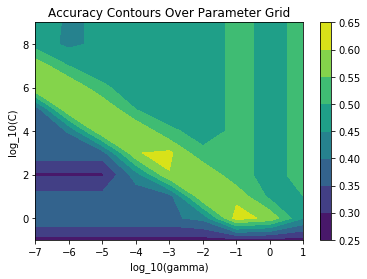

K-fold CV random state:	 42
Best fold accuracy:	0.6220
Best estimator__C:	1.00e+00
Best estimator__gamma:	1.00e-01


In [353]:
param_grid = {'estimator__C': np.logspace(-1,9,11), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
C_old, gamma_old = model_opt_old(classifier='svc', 
                                 seed=42, 
                                 param_grid=param_grid)

avg_train_accu
[[0.273 0.273 0.273 0.273 0.273 0.273 0.273 0.273 0.273]
 [0.399 0.391 0.391 0.391 0.391 0.428 0.69  0.856 0.86 ]
 [0.39  0.39  0.39  0.39  0.418 0.686 0.84  0.852 0.852]
 [0.281 0.281 0.281 0.467 0.686 0.825 0.855 0.852 0.852]
 [0.392 0.391 0.393 0.684 0.817 0.85  0.852 0.852 0.852]
 [0.402 0.424 0.684 0.817 0.848 0.854 0.852 0.852 0.852]
 [0.4   0.684 0.817 0.848 0.854 0.852 0.852 0.852 0.852]
 [0.707 0.824 0.848 0.854 0.852 0.852 0.852 0.852 0.852]
 [0.779 0.848 0.854 0.852 0.852 0.852 0.852 0.852 0.852]
 [0.667 0.786 0.852 0.852 0.852 0.852 0.852 0.852 0.852]
 [0.645 0.781 0.852 0.852 0.852 0.852 0.852 0.852 0.852]]
avg_test_accu
[[0.29  0.29  0.29  0.29  0.29  0.29  0.29  0.29  0.29 ]
 [0.384 0.384 0.384 0.384 0.384 0.418 0.624 0.592 0.45 ]
 [0.373 0.373 0.373 0.373 0.387 0.602 0.592 0.493 0.491]
 [0.307 0.307 0.307 0.424 0.602 0.604 0.517 0.493 0.506]
 [0.39  0.39  0.39  0.602 0.616 0.516 0.517 0.493 0.506]
 [0.39  0.417 0.602 0.604 0.516 0.476 0.517 0.493 0.506]
 

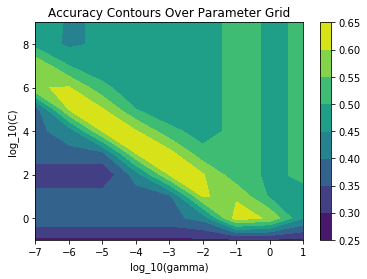

K-fold CV random state:	 42
Best fold accuracy:	0.6240
Best Parameters:  {'C': 1.0, 'gamma': 0.1}


In [354]:
param_grid = {'estimator__C': np.logspace(-1,9,11), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
C, gamma = model_opt_new(classifier='svc', 
                             aug_type='none', 
                             k=0, 
                             feat_data=X_enm, 
                             bin_data=bin_enm, 
                             seed=42, 
                             save_fig_name=None, 
                             show_opt_plot=True, 
                             show_cnf_matrix=False, 
                             param_grid=param_grid)

In [355]:
# Test results
are_equal(C_old, C)
are_equal(gamma_old, gamma)

True
True


But optimization plots do not look the same...

### Model evaluation

There are no tests for this yet.

#### ENM-only SVC-RBF

Score Dimensions:  (9, 9)


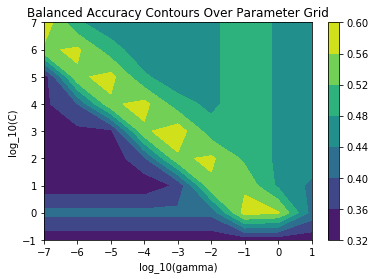

K-fold CV random state:	 42
Best fold balanced accuracy:	0.5890
Best Parameters:  {'C': 10000000.0, 'gamma': 1e-07}
Confusion matrix, without normalization
[[24  7  5]
 [ 9 15  5]
 [ 4  4  9]]
Normalized confusion matrix
[[0.67 0.19 0.14]
 [0.31 0.52 0.17]
 [0.24 0.24 0.53]]
Average normalized accuracy:  0.5711066035609647


0.5711066035609647

In [29]:
# Balanced accuracy
param_grid = {'estimator__C': np.logspace(-1,7,9), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
blt.model_opt_exe(classifier='svc', 
                  aug_type='none', 
                  k=0, 
                  feat_data=X_enm, 
                  bin_data=bin_enm, 
                  seed=42, 
                  save_fig_name=None, 
                  show_opt_plot=True, 
                  show_feat_impt=False, 
                  show_cnf_matrix=False, 
                  use_balanced_accu=True, # Balanced accuracy
                  param_grid=param_grid)

Score Dimensions:  (9, 9)


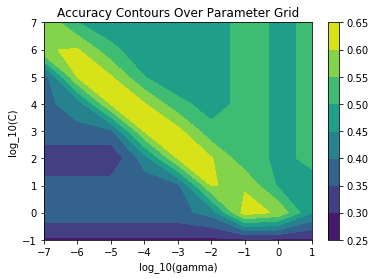

K-fold CV random state:	 42
Best fold accuracy:	0.6240
Best Parameters:  {'C': 1.0, 'gamma': 0.1}
Confusion matrix, without normalization
[[31  1  4]
 [13 12  4]
 [ 5  4  8]]
Normalized confusion matrix
[[0.86 0.03 0.11]
 [0.45 0.41 0.14]
 [0.29 0.24 0.47]]
Average normalized accuracy:  0.5818308166178349


0.5818308166178349

In [30]:
# Normal accuracy
blt.model_opt_exe(classifier='svc', 
                  aug_type='none', 
                  k=0, 
                  feat_data=X_enm, 
                  bin_data=bin_enm, 
                  seed=42, 
                  save_fig_name=None, 
                  show_opt_plot=True, 
                  show_feat_impt=False, 
                  show_cnf_matrix=False, 
                  use_balanced_accu=False, # Normal accuracy
                  param_grid=param_grid)

#### "Best" SVC-RBF from before

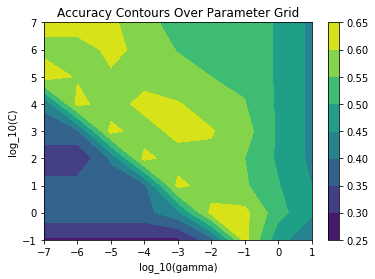

K-fold CV random state:	 42
Best fold accuracy:	0.6370
Best Parameters:  {'C': 10000000.0, 'gamma': 1e-06}
Confusion matrix, without normalization
[[23 11  2]
 [ 7 19  3]
 [ 4  4  9]]
Normalized confusion matrix
[[0.64 0.31 0.06]
 [0.24 0.66 0.1 ]
 [0.24 0.24 0.53]]
Average normalized accuracy:  0.6078243557959583


0.6078243557959583

In [32]:
param_grid = {'estimator__C': np.logspace(-1,7,9), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
# Normal accuracy
blt.model_opt_exe(classifier='svc', 
                  aug_type='sup_match', 
                  k=10, 
                  feat_data=X_enm, 
                  bin_data=bin_enm, 
                  seed=42, 
                  save_fig_name=None, 
                  show_opt_plot=True, 
                  show_feat_impt=False, 
                  show_cnf_matrix=False, 
                  use_balanced_accu=False,
                  param_grid=param_grid)

#### ENM only RFC

In [42]:
# 30 trials RFC optimizing max_depth and n_estimators 
model_params = {'classifier': 'rfc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__max_depth': np.arange(1,20,2), 
                               'estimator__n_estimators': [60,80]}
               }
blt.multi_trials(num_trials=30, model_params=model_params)

Avg accuracy:     0.6177196804647784
Median accuracy:  0.6211498009165353
StdDev accuracy:  0.02066580334532129
Numer of trials:  30


(0.6177196804647784,
 0.02066580334532129,
 array([0.09, 0.12, 0.07, 0.14, 0.03, 0.01, 0.  , 0.  , 0.04, 0.01, 0.02,
        0.02, 0.  , 0.02, 0.01, 0.01, 0.04, 0.02, 0.04, 0.03, 0.01, 0.  ,
        0.  , 0.01, 0.  , 0.01, 0.04, 0.01, 0.01, 0.  , 0.08, 0.  , 0.01,
        0.  , 0.02, 0.01, 0.03, 0.01]),
 array([4.91e-04, 1.02e-03, 4.89e-04, 6.90e-04, 1.47e-04, 4.11e-05,
        6.18e-06, 1.47e-05, 3.01e-04, 3.93e-05, 7.33e-05, 1.61e-04,
        6.55e-06, 6.28e-05, 4.74e-05, 2.07e-05, 5.57e-04, 7.36e-05,
        1.67e-04, 8.24e-05, 3.15e-05, 1.05e-06, 5.38e-06, 3.26e-05,
        1.23e-05, 6.16e-05, 2.36e-04, 1.16e-05, 3.93e-05, 1.32e-06,
        2.55e-04, 5.40e-06, 2.47e-05, 1.20e-05, 1.39e-04, 1.50e-05,
        1.35e-04, 3.71e-05]))